# Notebook 10: Phase 4 - Robustness & Interpretability (Đánh giá Bền vững & Diễn giải Mô hình)

## 1. Giới thiệu

**Mục tiêu chính:**
1.  **Kiểm định Bền vững (Robustness Check):** Sử dụng phương pháp **Rolling Window Cross-Validation** (Kiểm định cửa sổ cuộn) để xem mô hình có hoạt động ổn định qua từng năm hay không, thay vì chỉ kiểm tra tại một điểm cắt (2015).
2.  **Phân tích Phần dư (Residual Analysis):** Kiểm tra xem lỗi của mô hình có tuân theo các giả định thống kê hay không (phân phối chuẩn, tự tương quan).
3.  **Diễn giải Mô hình (Interpretability):** Xác định các yếu tố (feature) nào quan trọng nhất trong việc thúc đẩy lượng khí thải CO2.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
import json
import os
import sys

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

# Định nghĩa đường dẫn
DATA_DIR = '../data/processed'
RESULTS_DIR = '../data/results'

## 2. Nạp Dữ liệu & Siêu tham số (Data & Parameters)

Chúng ta cần dữ liệu đã tiền xử lý (`lr_final_prep.csv`) và tham số tốt nhất (`best_hyperparameters.json`) từ giai đoạn Tune. Quan trọng là mô hình Linear Regression sẽ được kiểm tra ở đây trước, vì nó là nền tảng.

In [2]:
# Load dữ liệu
try:
    df_model = pd.read_csv(os.path.join(DATA_DIR, 'lr_final_prep.csv'))
    df_common = pd.read_csv(os.path.join(DATA_DIR, 'common_preprocessed.csv'))
    print(f"Dữ liệu mô hình: {df_model.shape}")
except Exception as e:
    print(f"Lỗi load dữ liệu: {e}")
    
# Load tham số tốt nhất
try:
    with open(os.path.join(RESULTS_DIR, 'best_hyperparameters.json'), 'r') as f:
        best_params = json.load(f)
    # Lấy tham số cho Linear Regression, nếu không có lấy mặc định
    params_lr = best_params.get('Linear Regression', {'alpha': 1.0})
    print(f"Tham số LR: {params_lr}")
except Exception as e:
    print(f"Lỗi load tham số: {e}")
    params_lr = {'alpha': 1.0}

Dữ liệu mô hình: (3260, 196)
Tham số LR: {'alpha': 1.0}


In [3]:
# Khôi phục cột Year/Entity nếu bị thiếu trong df_model (để dùng cho rolling CV)
if 'Year' not in df_model.columns and len(df_model) == len(df_common):
    df_model['Year'] = df_common['Year']

if 'Entity' not in df_model.columns and len(df_model) == len(df_common):
    df_model['Entity'] = df_common['Entity']

TARGET = 'Value_co2_emissions_kt_by_country'

## 3. Rolling Window Cross-Validation (Kiểm định cửa sổ cuộn)

Thay vì chỉ cắt tại 2015, ta sẽ "cuộn" cửa sổ thời gian:
- Train: < 2015 | Test: 2015
- Train: < 2016 | Test: 2016
- ...
- Train: < 2019 | Test: 2019

Điều này mô phỏng việc dự báo thực tế từng năm một và kiểm tra độ ổn định của mô hình.

In [4]:
def rolling_window_cv(df, target_col, start_year=2015, end_year=2019):
    print("Bắt đầu Rolling Window CV...")
    results = []
    
    # Lọc các cột số để đưa vào mô hình (trừ target và các cột metadata)
    exclude_cols = [target_col, 'Year', 'Entity', 'Code', 'Cluster']
    feature_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)
    
    # Sử dụng mô hình Ridge với tham số tối ưu
    model = Ridge(**params_lr)
    
    years = range(start_year, end_year + 1)
    
    for year in years:
        # Tách Train/Test set theo năm
        train_mask = df['Year'] < year
        test_mask = df['Year'] == year
        
        X_train = df.loc[train_mask, feature_cols]
        y_train = df.loc[train_mask, target_col]
        
        X_test = df.loc[test_mask, feature_cols]
        y_test = df.loc[test_mask, target_col]
        
        if len(X_test) == 0:
            print(f"Cảnh báo: Không có dữ liệu cho năm {year}")
            continue
            
        # Huấn luyện và Dự báo
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Tính Scores
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        results.append({
            'Year': year,
            'R2': r2,
            'RMSE': np.sqrt(mse)
        })
        
        print(f" Năm {year}: R2 = {r2:.4f}, RMSE = {np.sqrt(mse):,.0f}")
        
    return pd.DataFrame(results)

# Thực thi
df_rolling = rolling_window_cv(df_model, TARGET)

Bắt đầu Rolling Window CV...
 Năm 2015: R2 = 0.9971, RMSE = 45,889
 Năm 2016: R2 = 0.9988, RMSE = 29,460
 Năm 2017: R2 = 0.9996, RMSE = 17,408
 Năm 2018: R2 = 0.9997, RMSE = 15,878
 Năm 2019: R2 = 0.9993, RMSE = 23,687


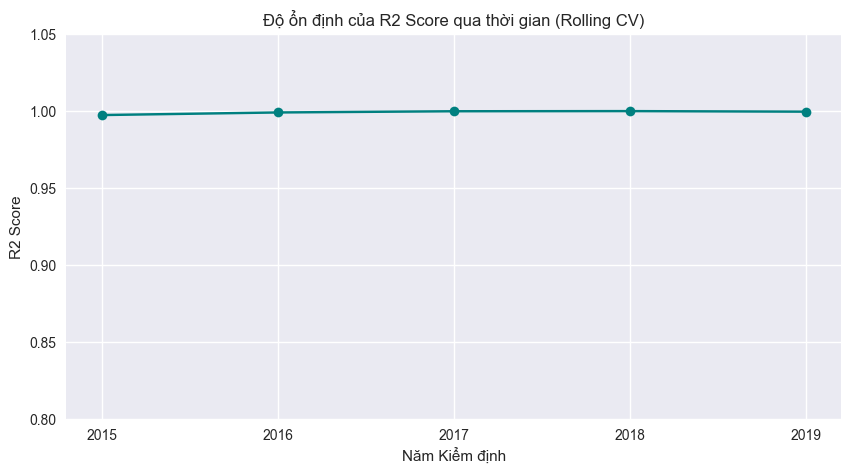

In [5]:
# Vẽ biểu đồ R2 qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df_rolling['Year'], df_rolling['R2'], marker='o', linestyle='-', color='teal')
plt.title('Độ ổn định của R2 Score qua thời gian (Rolling CV)')
plt.xlabel('Năm Kiểm định')
plt.ylabel('R2 Score')
plt.ylim(0.8, 1.05) # Zoom vào vùng cao vì R2 thường rất cao
plt.grid(True)
plt.xticks(df_rolling['Year'])
plt.show()

## 4. Phân tích Phần dư (Residual Analysis)

Check các giả định thống kê:
1.  **Phân phối chuẩn của phần dư:** Histogram và Q-Q Plot.
2.  **Tính đồng nhất phương sai (Homoscedasticity):** Scatter plot giữa Dự báo và Phần dư.
3.  **Tự tương quan (Autocorrelation):** Durbin-Watson test.

_Lưu ý: Ta sẽ lấy phần dư từ lần dự báo cuối cùng (năm 2019) để phân tích._

In [6]:
# Chạy lại mô hình cho năm split cuối để lấy residuals
exclude_cols = [TARGET, 'Year', 'Entity', 'Code', 'Cluster']
feature_cols = df_model.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

split_year = 2019
train_mask = df_model['Year'] < split_year
test_mask = df_model['Year'] == split_year

model = Ridge(**params_lr)
model.fit(df_model.loc[train_mask, feature_cols], df_model.loc[train_mask, TARGET])
y_test_last = df_model.loc[test_mask, TARGET]
y_pred_last = model.predict(df_model.loc[test_mask, feature_cols])

residuals = y_test_last - y_pred_last

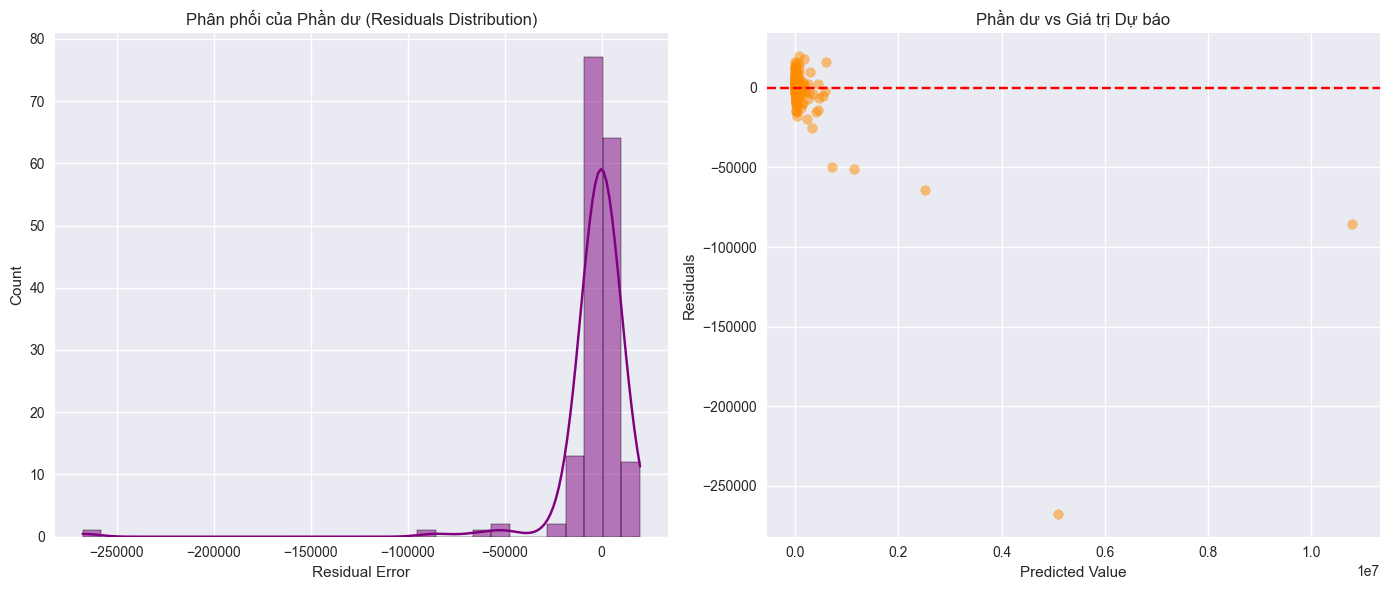


Durbin-Watson Statistic: 2.0683
 (Giá trị gần 2.0 = Không có tự tương quan. < 1.0 hoặc > 3.0 là đáng lo ngại)


In [7]:
plt.figure(figsize=(14, 6))

# 1. Histogram Residuals
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title('Phân phối của Phần dư (Residuals Distribution)')
plt.xlabel('Residual Error')

# 2. Residuals vs Predicted (Homoscedasticity)
plt.subplot(1, 2, 2)
plt.scatter(y_pred_last, residuals, alpha=0.5, color='darkorange')
plt.axhline(0, color='red', linestyle='--')
plt.title('Phần dư vs Giá trị Dự báo')
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Durbin-Watson Test
dw_score = durbin_watson(residuals)
print(f"\nDurbin-Watson Statistic: {dw_score:.4f}")
print(" (Giá trị gần 2.0 = Không có tự tương quan. < 1.0 hoặc > 3.0 là đáng lo ngại)")

## 5. Tầm quan trọng của Đặc trưng (Feature Importance)

Xem xét các hệ số (Coefficients) của mô hình Ridge để hiểu đặc trưng nào tác động mạnh nhất đến dự báo CO2.

C:\Users\MaiVu\AppData\Local\Temp\ipykernel_22732\4004775613.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Feature', x='Coefficient', data=top_features, palette='viridis')


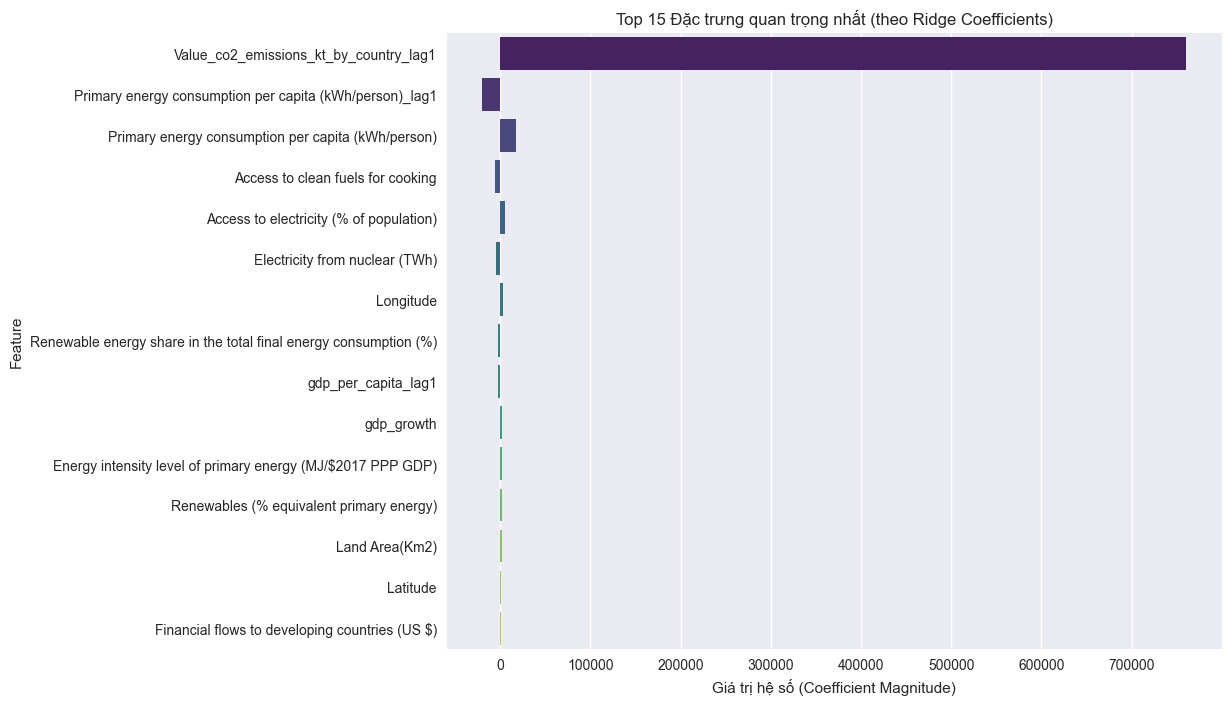

Chi tiết Top Features:
                                              Feature    Coefficient
17             Value_co2_emissions_kt_by_country_lag1  760621.696298
13  Primary energy consumption per capita (kWh/per...  -20497.079279
12  Primary energy consumption per capita (kWh/per...   17537.302016
0                   Access to clean fuels for cooking   -5575.475148
1             Access to electricity (% of population)    5322.384223
4                      Electricity from nuclear (TWh)   -4448.496188
10                                          Longitude    2847.596654
14  Renewable energy share in the total final ener...   -2358.419225
20                                gdp_per_capita_lag1   -2350.613921
18                                         gdp_growth    2244.431253
6   Energy intensity level of primary energy (MJ/$...    2237.995451
16           Renewables (% equivalent primary energy)    2110.715340
8                                      Land Area(Km2)    2100.925710
9          

In [8]:
# Lấy coefficients và tên cột
coefs = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_,
    'Abs_Coef': np.abs(model.coef_)
})

# Sắp xếp theo độ lớn tuyệt đối
top_features = coefs.sort_values('Abs_Coef', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(y='Feature', x='Coefficient', data=top_features, palette='viridis')
plt.title('Top 15 Đặc trưng quan trọng nhất (theo Ridge Coefficients)')
plt.xlabel('Giá trị hệ số (Coefficient Magnitude)')
plt.grid(True, axis='x')
plt.show()

print("Chi tiết Top Features:")
print(top_features[['Feature', 'Coefficient']])